In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import scipy
from scipy import stats
%pylab inline
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import statsmodels.formula.api as smf
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import shapefile
import Quandl
from tabulate import tabulate

Populating the interactive namespace from numpy and matplotlib


## 1. Markov process

A Markov process (specifically we'll consider the simplest version of Markov chain) $\{X_t\}$ is a stochastic process with discrete outcomes with the property that, 
given the outcome of $X_t$, the outcome of $X_{t+1}$ is no further affected by the previous outcomes of 
$\{X_u\}$ for $u < t$.  Therefore, $Pr(X_{t+1} \big| X_t, X_{t-1}, ...) = Pr(X_{t+1} \big| X_t)$.

Then the process is fully described by probabilities $p_{ij}(t)=P(X_{t+1}=j|X_t=i)$ of transitioning from state i to state j at the moment $t$. Those are called transition probabilities, while the matrix $T(t)=\{p_{ij}(t)\}$ is called a transition matrix. If those probabilities do not depend on $t$ they are called stationary (do not confuse with the definition of a stationary process).

So knowing current state of the system and a transition matrix is all we need in order to predict its further states (prediction is not deterministic though, but probabilistic, however current state of the system gives all necessary information for it).

Admitting uncertainty for a current state $i$ of the system during the moment $t$, being described as a probability distribution $\pi(t)=\{\pi_i\}$ (being a normalized column vector, such that $\sum_i \pi_i=1$) one can write 
$$
\pi(t+1)=T(t)'\pi(t).
$$
If the transition matrix is a stationary one $T(t)=T$ then
$$
\pi(t)=\left(T^t\right)' \pi(0)
$$
There is usually one signle vector $\pi^*$ such that
$$
\pi^*=T \pi^*
$$
(eigenvector for a unit eigenvalue). Vector $\pi^*$ is called a stationary distribution of the system and there is usually one single vector $\pi^*$ like that. And as long as the process is irreducible and aperiodic (see below) and also so called positive recurrent, whatever distribution vector $\pi(0)$ for the initial state of the system we'll start from, 
$$
\pi(t)=\left(T^t\right)' \pi(0) \to \pi^*
$$
for $t\to \infty$, i.e. we'll asymptotically always end up with the same distribution for the system states - then this distribution is also called equilibrium distribution of the chain.

Special cases.

1. Deterministic process - all the probabilities $p_{ik}$ are either zeros or ones. For example, current day of the week could be though as a deterministic Markov process a deterministic transition between today's and tomorrow's weekday.

2. Reducible process - if there exist a pair of states $i$ and $j$ such that $j$ can never be accessed from $i$. For example any process with closed states (having a zero probability of leaving them) is reducible.

3. Process with periodic states - after getting to it, the system always gets back to it after a cetrain period of time $d$. For example  deterministic processes are often periodic (thus "day of the week" process have a period of $7$) unless they converge to one signle absorbing state (i.e. are reducible). If system does not have any periodic states it is called aperiodic. 

In [3]:
net13 = pd.read_csv( 'https://serv.cusp.nyu.edu/files/ADS-2015/MorningSection/lab8/net10M.csv' , index_col=None, header=None )
net13W = pd.read_csv( 'https://serv.cusp.nyu.edu/files/ADS-2015/MorningSection/lab8/net10Mw.csv' , index_col=None, header=None )

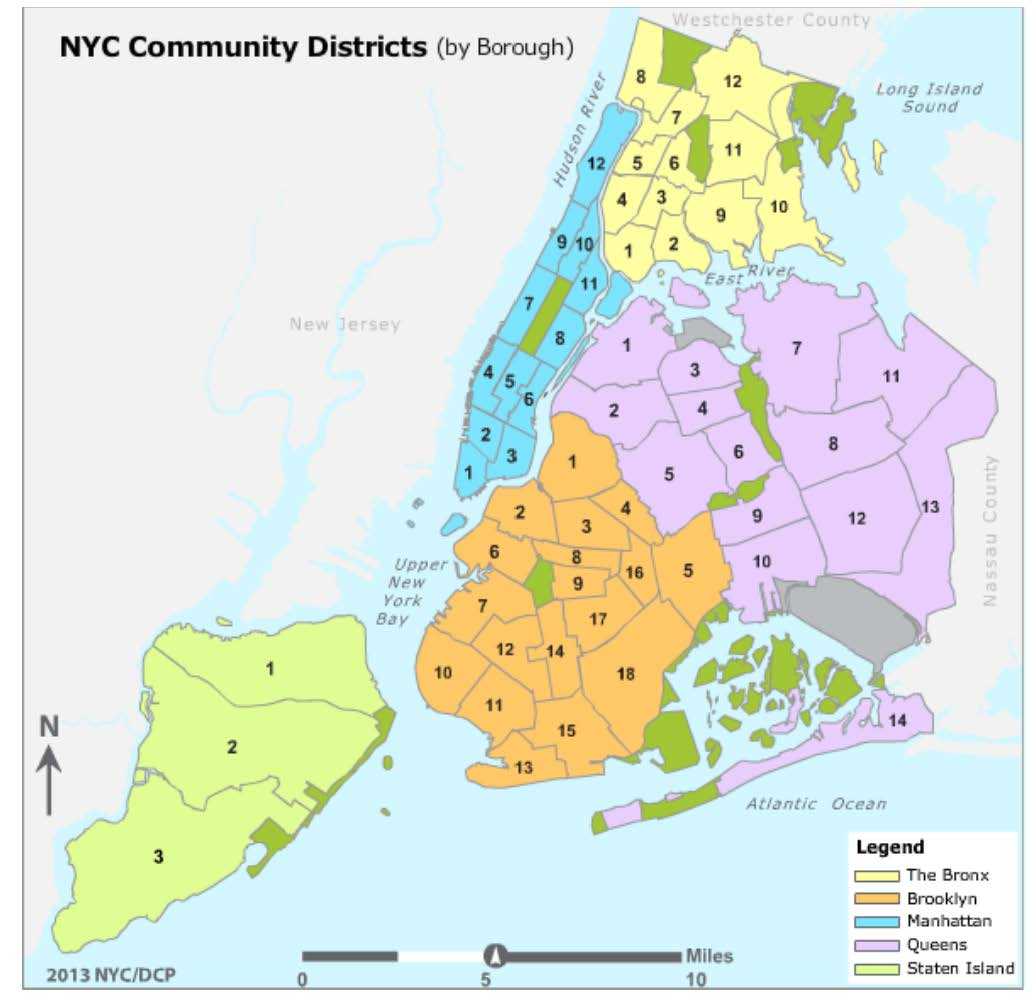

In [3]:
#source: http://www.nyc.gov/html/dcp/html/neigh_info/nhmap.shtml
from IPython.display import Image
Image(filename='NYCCommunityDistricts.jpg')

In [4]:
net13

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,43045,47251,14135,34320,61352,21868,5277,12692,488,295,817,327,24530
1,41238,94385,27210,70441,116045,31851,9465,18006,827,355,817,404,24111
2,10169,28060,17603,13180,29962,19464,2192,6165,245,200,557,126,11385
3,28706,64060,12020,139295,183807,37258,48590,38463,4132,1815,2846,1713,33343
4,63368,118304,29066,154423,461942,126482,73545,151353,4878,2651,6748,1955,101934
5,21846,38729,21562,35445,153419,99678,19919,88312,1675,1127,4026,884,36102
6,5799,10472,2317,46593,89710,17517,177826,95788,23644,6728,11337,4228,33184
7,14777,20873,8273,31554,175482,82771,102630,363239,7955,4683,30765,2374,48231
8,484,900,239,3288,5077,1126,16615,5682,6761,2554,2453,1497,4354
9,130,230,112,774,1370,445,2962,1866,1953,2031,1745,230,1877


In [5]:
#compute transition probabilities based on the observed statistics
T=1.0*net13.as_matrix()
for i in range(0,13):
    T[i,:]=T[i,:]/sum(T[i,:])

In [6]:
pd.DataFrame(T)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.161582,0.177371,0.053060,0.128830,0.230303,0.082088,0.019809,0.047643,0.001832,0.001107,0.003067,0.001227,0.092081
1,0.094766,0.216900,0.062529,0.161876,0.266675,0.073195,0.021751,0.041378,0.001900,0.000816,0.001877,0.000928,0.055408
2,0.072997,0.201424,0.126360,0.094611,0.215077,0.139719,0.015735,0.044254,0.001759,0.001436,0.003998,0.000904,0.081725
3,0.048161,0.107475,0.020166,0.233698,0.308376,0.062508,0.081520,0.064530,0.006932,0.003045,0.004775,0.002874,0.055940
4,0.048871,0.091238,0.022416,0.119094,0.356258,0.097545,0.056719,0.116726,0.003762,0.002045,0.005204,0.001508,0.078613
5,0.041793,0.074091,0.041249,0.067808,0.293499,0.190690,0.038106,0.168946,0.003204,0.002156,0.007702,0.001691,0.069065
6,0.011043,0.019941,0.004412,0.088724,0.170830,0.033357,0.338624,0.182404,0.045024,0.012812,0.021588,0.008051,0.063190
7,0.016536,0.023358,0.009258,0.035311,0.196375,0.092626,0.114849,0.406486,0.008902,0.005241,0.034428,0.002657,0.053973
8,0.009485,0.017637,0.004684,0.064433,0.099490,0.022065,0.325593,0.111346,0.132491,0.050049,0.048070,0.029336,0.085322
9,0.008267,0.014626,0.007122,0.049221,0.087122,0.028299,0.188362,0.118665,0.124197,0.129157,0.110970,0.014626,0.119364


In [11]:
#simulate the process where a taxi starts in Lower Manhattan and at each step performs a trip according to the probabilities above
pi=[0]*13
pi[0]=1
pi=np.matrix(pi).reshape(13,1)
print(["%.2f"%x for x in 100*np.array(pi)])
#print tabulate(100*pi.transpose(),tablefmt="plain",floatfmt=".2f")
for k in range(0,10):
    pi=T.transpose()*pi
    #print(tabulate(pi.transpose(), tablefmt="fancy_grid", numalign = "center"))
    print(["%.2f"%x for x in 100*np.array(pi)])

['100.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['16.16', '17.74', '5.31', '12.88', '23.03', '8.21', '1.98', '4.76', '0.18', '0.11', '0.31', '0.12', '9.21']
['7.27', '12.47', '3.99', '12.74', '27.90', '9.21', '5.53', '9.96', '0.54', '0.29', '0.71', '0.23', '9.15']
['5.65', '10.19', '3.25', '11.78', '27.87', '9.20', '7.54', '12.94', '0.84', '0.42', '1.06', '0.29', '8.97']
['5.14', '9.27', '2.94', '11.22', '27.37', '9.09', '8.55', '14.39', '1.02', '0.51', '1.28', '0.33', '8.89']
['4.93', '8.86', '2.81', '10.94', '27.05', '9.01', '9.05', '15.07', '1.12', '0.55', '1.40', '0.36', '8.86']
['4.83', '8.67', '2.75', '10.80', '26.88', '8.97', '9.29', '15.39', '1.17', '0.58', '1.46', '0.37', '8.85']
['4.79', '8.58', '2.72', '10.74', '26.79', '8.95', '9.41', '15.53', '1.19', '0.59', '1.48', '0.38', '8.84']
['4.76', '8.54', '2.71', '10.71', '26.75', '8.94', '9.47', '15.60', '1.21', '0.60', '1.50', '0.38', '8.84']
['4.75', '8.52', '2.70', '1

In [12]:
T10=np.linalg.matrix_power(T,10)
print(tabulate(np.matrix(range(1,14)),floatfmt=".2f"))
print(tabulate(100*T10,floatfmt=".2f"))

------------------------------------------
[[ 1  2  3  4  5  6  7  8  9 10 11 12 13]]
------------------------------------------
----  ----  ----  -----  -----  ----  ----  -----  ----  ----  ----  ----  ----
4.75  8.51  2.70  10.69  26.72  8.93  9.51  15.65  1.21  0.60  1.51  0.38  8.84
4.75  8.51  2.70  10.69  26.72  8.93  9.51  15.65  1.21  0.60  1.51  0.38  8.84
4.75  8.51  2.70  10.69  26.72  8.93  9.51  15.65  1.21  0.60  1.51  0.38  8.84
4.75  8.50  2.70  10.68  26.71  8.93  9.52  15.66  1.22  0.60  1.51  0.38  8.84
4.74  8.50  2.70  10.68  26.71  8.93  9.52  15.66  1.22  0.60  1.51  0.38  8.84
4.74  8.50  2.70  10.68  26.71  8.93  9.52  15.66  1.22  0.60  1.51  0.38  8.84
4.74  8.49  2.69  10.67  26.70  8.92  9.54  15.69  1.22  0.61  1.52  0.38  8.84
4.74  8.49  2.70  10.68  26.70  8.92  9.54  15.68  1.22  0.60  1.51  0.38  8.84
4.73  8.48  2.69  10.67  26.69  8.92  9.55  15.69  1.22  0.61  1.52  0.38  8.84
4.73  8.48  2.69  10.67  26.69  8.92  9.55  15.70  1.22  0.61  1.52  0.

In [13]:
Tw=1.0*net13W.as_matrix()
for i in range(0,13):
    Tw[i,:]=Tw[i,:]/sum(Tw[i,:])

In [14]:
T10w=np.linalg.matrix_power(Tw,10)
print(tabulate(100*T10w,floatfmt=".2f"))

----  ----  ----  -----  -----  ----  ----  -----  ----  ----  ----  ----  -----
4.16  9.36  5.85  11.11  17.85  8.76  8.91  11.90  1.53  1.15  1.95  0.87  16.59
4.16  9.36  5.85  11.11  17.85  8.76  8.91  11.90  1.53  1.15  1.95  0.87  16.59
4.16  9.36  5.85  11.11  17.85  8.76  8.91  11.90  1.53  1.15  1.95  0.87  16.59
4.16  9.36  5.84  11.11  17.85  8.76  8.91  11.90  1.53  1.15  1.96  0.87  16.59
4.16  9.36  5.84  11.11  17.85  8.76  8.91  11.90  1.53  1.15  1.96  0.87  16.59
4.16  9.36  5.84  11.11  17.85  8.76  8.91  11.90  1.53  1.15  1.96  0.87  16.59
4.16  9.35  5.84  11.11  17.84  8.76  8.92  11.91  1.54  1.15  1.96  0.87  16.58
4.16  9.35  5.84  11.11  17.84  8.76  8.91  11.90  1.54  1.15  1.96  0.87  16.59
4.16  9.35  5.84  11.11  17.84  8.76  8.92  11.91  1.54  1.15  1.96  0.88  16.58
4.16  9.35  5.84  11.11  17.84  8.76  8.92  11.91  1.54  1.15  1.96  0.88  16.58
4.16  9.35  5.84  11.11  17.84  8.76  8.92  11.91  1.54  1.15  1.96  0.88  16.58
4.16  9.35  5.84  11.11  17.

In [16]:
#plt.figure(figsize = (20,5))
#model.plot_predict(plot_insample=1)

## 2. Fitting ARIMA

In [12]:
crime = Quandl.get("FBI_UCR/USCRIME_TYPE_ROBBERIES", trim_start="1961-1-1", trim_end="2015-1-1")
pop = Quandl.get("MWORTH/0_3", trim_start="1961-1-1", trim_end="2011-1-1")

In [13]:
pop.head()

,Value
Year,
1961-12-31,183742
1962-12-31,186590
1963-12-31,189300
1964-12-31,191927
1965-12-31,194347


In [14]:
crime.head()

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,United States
Year,,,,,,,,,,,,,,,,,,,,,
1961-12-31,630,29,786,446,14832,1633,238,124,1348,3746,...,1100,3042,186,16,1065,902,216,361,121,106670
1962-12-31,754,34,851,400,15598,1624,258,140,1572,3457,...,1266,3192,217,18,1070,912,273,348,51,110860
1963-12-31,828,55,897,466,16458,1340,366,181,1707,4017,...,1048,3700,225,27,1267,914,260,393,72,116470
1964-12-31,992,53,967,565,18667,1323,414,203,2279,4958,...,1148,4479,263,13,1517,850,303,451,46,130390
1965-12-31,992,101,895,465,21081,1073,546,286,2881,5146,...,1100,4509,229,18,1780,905,261,475,61,138690


In [15]:
rate = crime['United States'] / pop

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/frame.py:3200: FutureWarning: TimeSeries broadcasting along DataFrame index by default is deprecated. Please use DataFrame.<op> to explicitly broadcast arithmetic operations along the index
  FutureWarning)


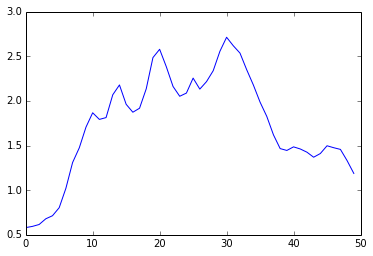

In [16]:
plt.plot(rate)

In [17]:
model2 = sma.tsa.ARIMA(rate.Value['1960':'1995'], order=(2,0,2)).fit()
print(model2.summary())

                              ARMA Model Results                              
Dep. Variable:                  Value   No. Observations:                   35
Model:                     ARMA(2, 2)   Log Likelihood                  21.969
Method:                       css-mle   S.D. of innovations              0.119
Date:                Sun, 01 Nov 2015   AIC                            -31.938
Time:                        23:11:58   BIC                            -22.606
Sample:                    12-31-1961   HQIC                           -28.717
                         - 12-31-1995                                         
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const           1.6420      0.269      6.115      0.000         1.116     2.168
ar.L1.Value     1.9469      0.036     54.252      0.000         1.877     2.017
ar.L2.Value    -0.9584      0.035    -27.587    

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


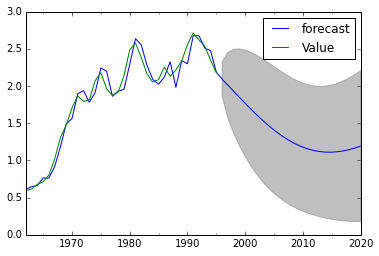

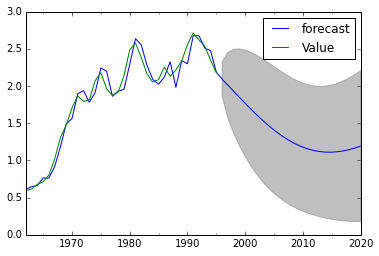

In [18]:
model2.plot_predict('1962','2020',plot_insample=1)

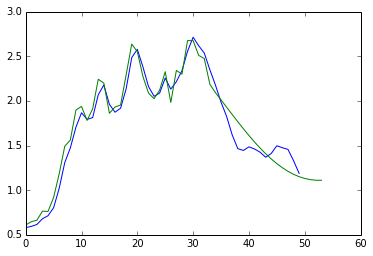

In [19]:
crimeP=model2.predict('1962','2015')
plt.plot(rate)
plt.plot(crimeP)

In [20]:
# Stats models has an ARMA estimator.  The AR component is simple: just linear regression.
# The MA component, however, requires the use of maximum likelihood estimation.
# Always have a back-up plan.

aapl_all = Quandl.get("YAHOO/AAPL", trim_start="2014-09-1", trim_end="2015-4-1")
aapl = aapl_all['Adjusted Close']
aapl_returns = np.log(aapl / aapl.shift(1))
aapl_returns = aapl_returns.dropna()
aapl_returns = pd.DataFrame(aapl_returns)

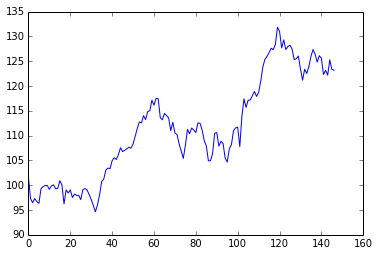

In [21]:
plt.plot(aapl)

In [22]:
model = sma.tsa.ARIMA(aapl_returns['Adjusted Close']['2014-9-1':'2015-1-1'], order=(4,1,2)).fit()
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:       D.Adjusted Close   No. Observations:                   83
Model:                 ARIMA(4, 1, 2)   Log Likelihood                 234.068
Method:                       css-mle   S.D. of innovations              0.014
Date:                Sun, 01 Nov 2015   AIC                           -452.137
Time:                        23:11:59   BIC                           -432.786
Sample:                    09-04-2014   HQIC                          -444.363
                         - 12-31-2014                                         
                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
const                   9.606e-06   7.59e-05      0.127      0.900        -0.000     0.000
ar.L1.D.Adjusted Close    -0.2492      0.532     -0.468      0.641        -1.292     0.794
ar.L

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


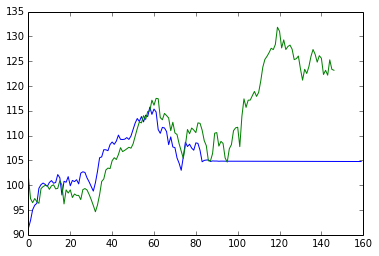

In [23]:
est=model.predict(1,160)
est=exp(-cumsum(est))
plt.plot(est/est[5]*aapl[5])
plt.plot(aapl)